# Определение стоимости автомобилей

<a id=0></a>
[Содержание](#0)

[1. Описание проекта](#1)

[2. Анализ данных](#2)

[3. Подготовка данных](#3)

[4. Обучение моделей](#4)

[5. Тестирование модели](#5)

[6. Общий вывод](#6)

<a id=1></a>
## 1. Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель проекта:**

Построить модель для определения стоимости автомобиля по входным данным.

Заказчику важны:

- Качество предсказания;
- Скорость предсказания;
- Время обучения.

**Данные:**

Данные находятся в файле:
`/datasets/autos.csv`

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (евро)

**План работы:**

1. Загрузить и изучить данные.

2. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.

3. Подготовить выборки для обучения моделей.

4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели подобрать гиперпараметры.

5. Проанализировать время обучения, время предсказания и качество моделей.

6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

7. Сделать вывод.

**Примечания:**

- Для оценки качества моделей применить метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Модель градиентного бустинга может долго обучаться, поэтому изменяем у неё только два-три параметра.

<a id=2></a>
[Содержание](#0)
## 2. Анализ данных

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RND_STATE = 28022023

In [65]:
try:
    cars_df = pd.read_csv('/datasets/autos.csv')
except:
    cars_df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим количество пропусков в процентах и в абсолютных величинах:

In [66]:
#display(pd.DataFrame(round(df_train.isna().mean()*100,)).style.background_gradient('coolwarm'))
def na_info(df):
    na_info = (df.isna() | df.isnull()).sum()
    res = (pd.concat([na_info / df.shape[0], na_info], axis=1,  keys = ['%', 'abs'])
           .sort_values('%', ascending = False))
    return res

na_info(cars_df).head()

,%,abs
Repaired,0.200791,71154
VehicleType,0.105794,37490
FuelType,0.092827,32895
Gearbox,0.055967,19833
Model,0.055606,19705


Пропуски в столбцах:

- Repaired
- VehicleType
- FuelType
- Gearbox
- Model

В дальнейшем их обработаем.

Посмотрим данные в датафреме:

In [67]:
cars_df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим граничные значения по столбцам:

In [68]:
cars_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Посмотрим уникальные значения данных в столбцах:

In [69]:
def show_unic(cars_df):
    for column in cars_df.columns:
        print('\n Уникальные значения столбца:', column)
        print(cars_df[column].unique())
        print(cars_df[column].value_counts())
        print(50*'-')

show_unic(cars_df)


 Уникальные значения столбца: DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: DateCrawled, Length: 271174, dtype: int64
--------------------------------------------------

 Уникальные значения столбца: Price
[  480 18300  9800 ... 12395 18429 10985]
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: Price, Length: 3731, dtype: int64
--------------------------------------------------

 Уникальные значения столбца: VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'ot

[ 0  5  8  6  7 10 12 11  2  3  1  4  9]
0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64
--------------------------------------------------

 Уникальные значения столбца: FuelType
['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
--------------------------------------------------

 Уникальные значения столбца: Brand
['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover'

Проверим датасет на наличие явных дубликатов и удалим их:

In [70]:
print(cars_df.duplicated().sum())
data = cars_df.drop_duplicates()
print(cars_df.shape)

4
(354369, 16)


**Целевой признак - Price**

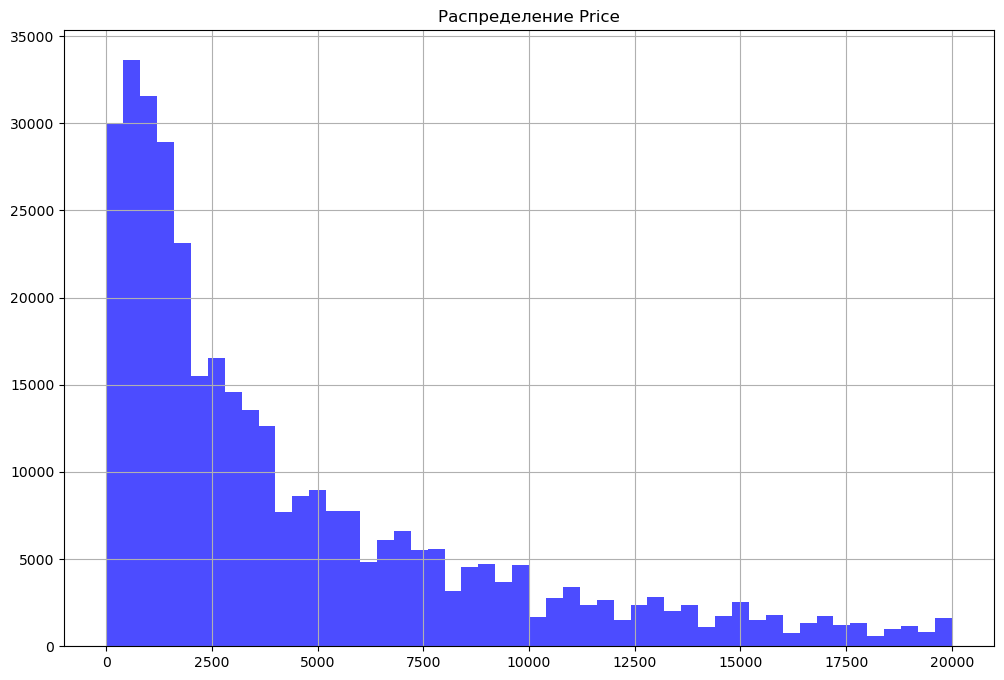

In [71]:
cars_df['Price'].hist(figsize=(12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение Price')
plt.show()

Посмотрим кол-во нулевых значений в целевом признаке:

In [72]:
print('Количество нулевых значений в колонке Price =', cars_df[cars_df['Price'] == 0]['Price'].count())
print('Количество значений в колонке Price > 20000 Euro =', cars_df[cars_df['Price'] > 20000]['Price'].count())

Количество нулевых значений в колонке Price = 10772
Количество значений в колонке Price > 20000 Euro = 0


Удалим строки с нулевой ценой:

In [73]:
cars_df = cars_df[cars_df['Price'] != 0]

**Признак - Power**

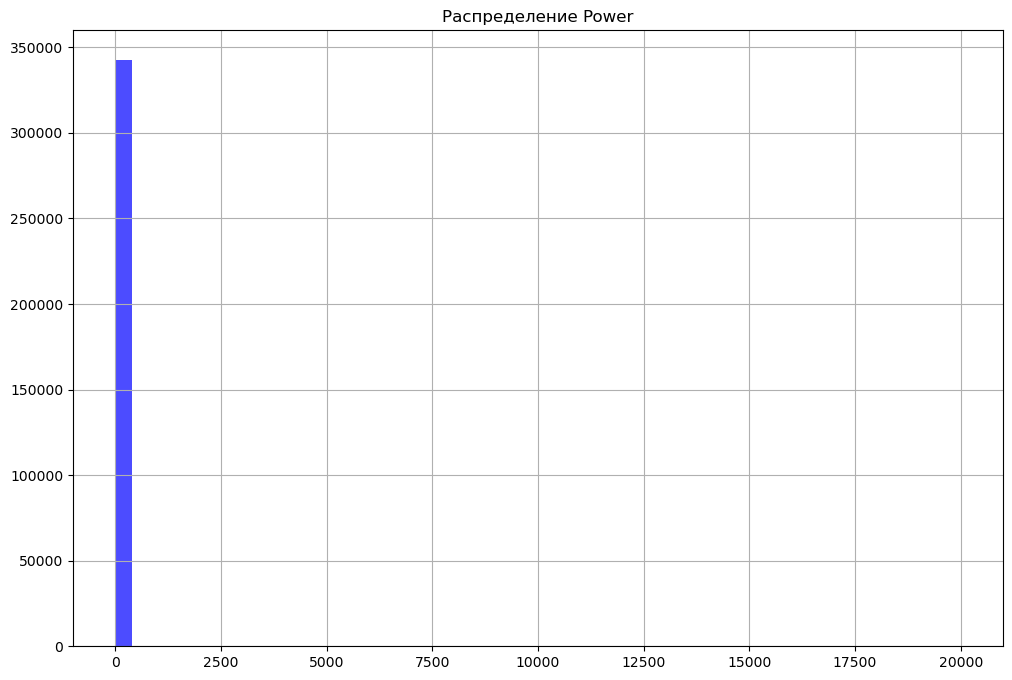

In [74]:
cars_df['Power'].hist(figsize=(12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение Power')
plt.show()

В колоке содержатся ошибочные данные:
- Нулевые данные
- В данных типа '31' или '29' пропустили '1' слева
- В данных типа '1595' или '776' пропущена '.' справа на 1 десятичный знак
- В данных типа '17700' или '11025' пропущена '.' справа на 2 десятичных знака

Заменим нулевые данные медианным значением по бренду и скорректируем остальные данные в колонке Power:

In [75]:
print('Количество нулевых значений в колонке Power =', cars_df[cars_df['Power'] == 0]['Power'].count())
cars_df.loc[cars_df['Power'] == 0, 'Power'] = np.NaN
cars_df.loc[cars_df['Power'].isna(), 'Power'] = cars_df.groupby('Brand')['Power'].transform('mean')
print('Количество нулевых значений в колонке Power =', cars_df[cars_df['Power'] == 0]['Power'].count())

Количество нулевых значений в колонке Power = 36360
Количество нулевых значений в колонке Power = 0


In [76]:
max_Power = cars_df[cars_df['Power'] > 500]['Power'].count()
print('Количество значений в колонке Power > 500 л.с. =', max_Power)

while max_Power > 0:
    cars_df.loc[cars_df['Power'] > 500, 'Power'] = cars_df['Power'] / 10
    max_Power = cars_df[cars_df['Power'] > 500]['Power'].count()
    print('Количество значений в колонке Power > 500 л.с. =', max_Power)

Количество значений в колонке Power > 500 л.с. = 429
Количество значений в колонке Power > 500 л.с. = 78
Количество значений в колонке Power > 500 л.с. = 0


In [77]:
print('Количество значений в колонке Power < 50 л.с. =', cars_df[cars_df['Power'] < 50]['Power'].count())
cars_df.loc[cars_df['Power'] < 50, 'Power'] = cars_df['Power'] + 100
cars_df['Power'] = np.int64(cars_df['Power'])
print('Количество значений в колонке Power < 50 л.с. =', cars_df[cars_df['Power'] < 50]['Power'].count())

Количество значений в колонке Power < 50 л.с. = 5922
Количество значений в колонке Power < 50 л.с. = 0


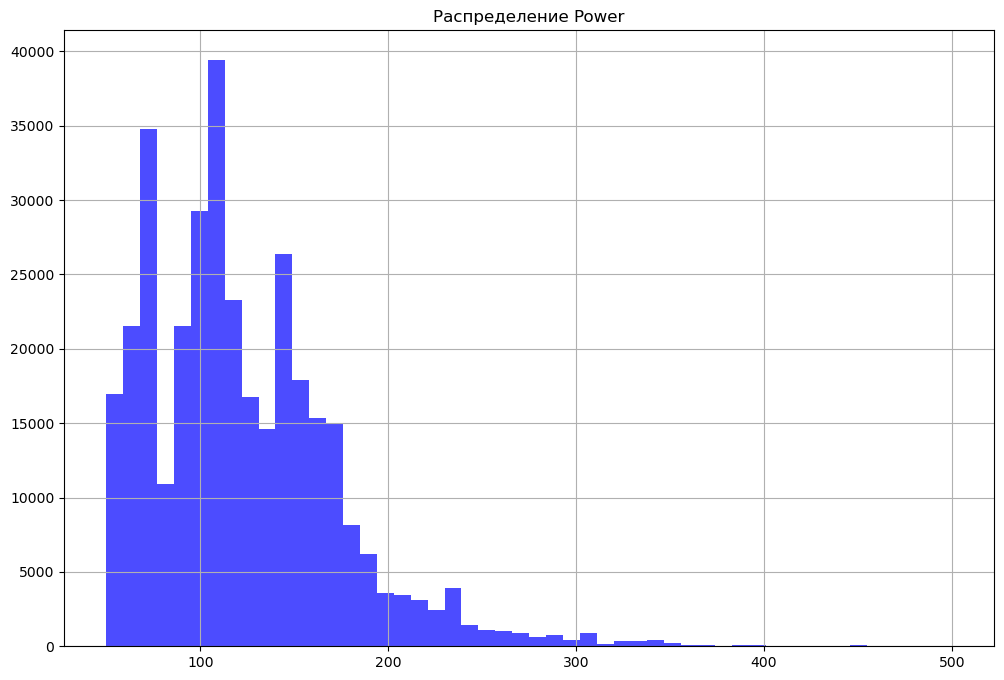

In [78]:
cars_df['Power'].hist(figsize = (12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение Power')
plt.show()

**Признак - RegistrationYear**

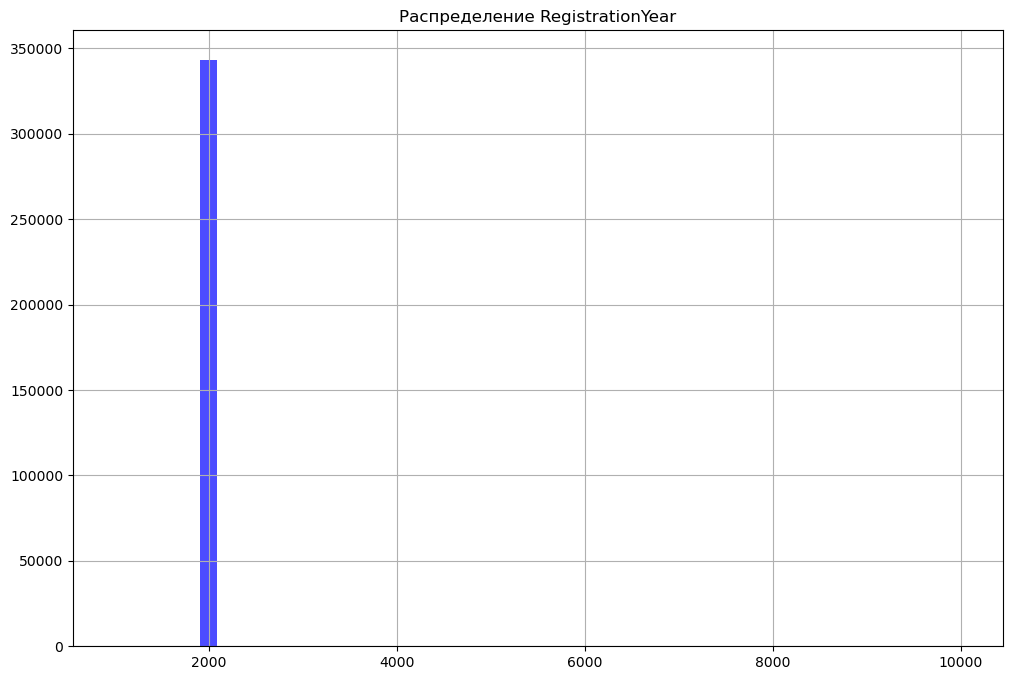

In [79]:
cars_df['RegistrationYear'].hist(figsize = (12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение RegistrationYear')
plt.show()

Посмотрим максимальную дату скачивания анкеты автомобиля, для ограничения по дате регистрации:

In [80]:
DateCrawled_max = pd.to_datetime(cars_df['DateCrawled'].max()).year
print(DateCrawled_max)

2016


Посмотрим данные в колонке:

In [81]:
print('Количество значений в колонке RegistrationYear < 1970 =', cars_df[cars_df['RegistrationYear'] < 1970]['RegistrationYear'].count())
print('Количество значений в колонке RegistrationYear > 2016 =', cars_df[cars_df['RegistrationYear'] > 2022]['RegistrationYear'].count())

Количество значений в колонке RegistrationYear < 1970 = 1175
Количество значений в колонке RegistrationYear > 2016 = 86


Коллекционные автомобили имеют другое ценообразование, исключим информацию о них из датасета вместе с некорректными данными.

Так же удалим данные об автомобилях с датой регистрации больше 2016г.

In [82]:
cars_df = cars_df.loc[(cars_df['RegistrationYear'] > 1970) & (cars_df['RegistrationYear'] <= DateCrawled_max)]

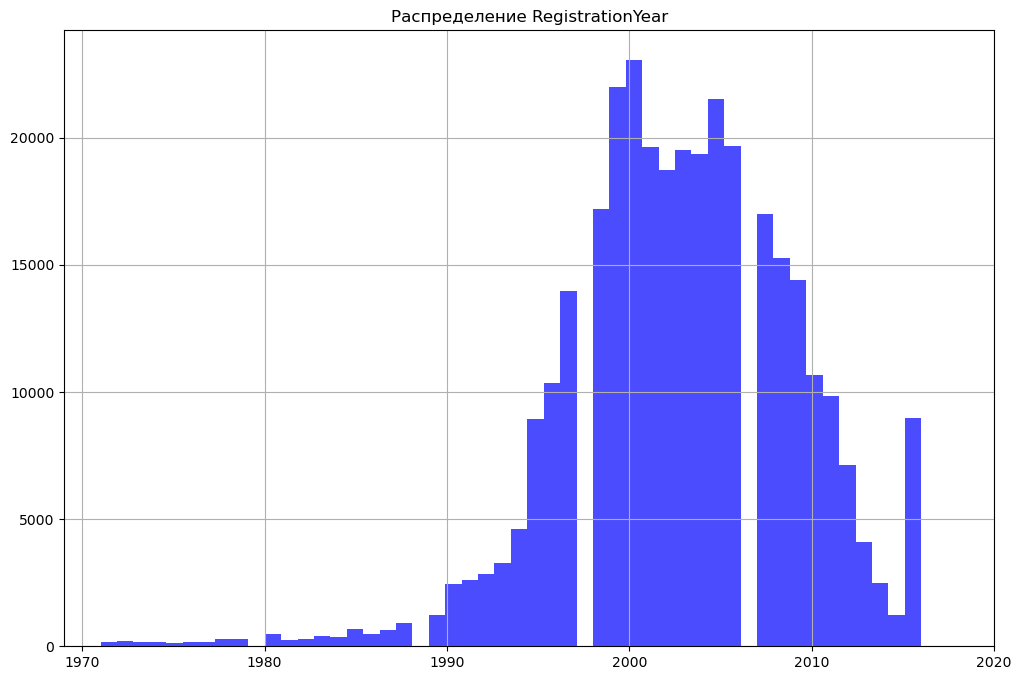

In [83]:
cars_df['RegistrationYear'].hist(figsize = (12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение RegistrationYear')
plt.xlim(1969, 2020)
plt.show()

**Признак - Kilometer**

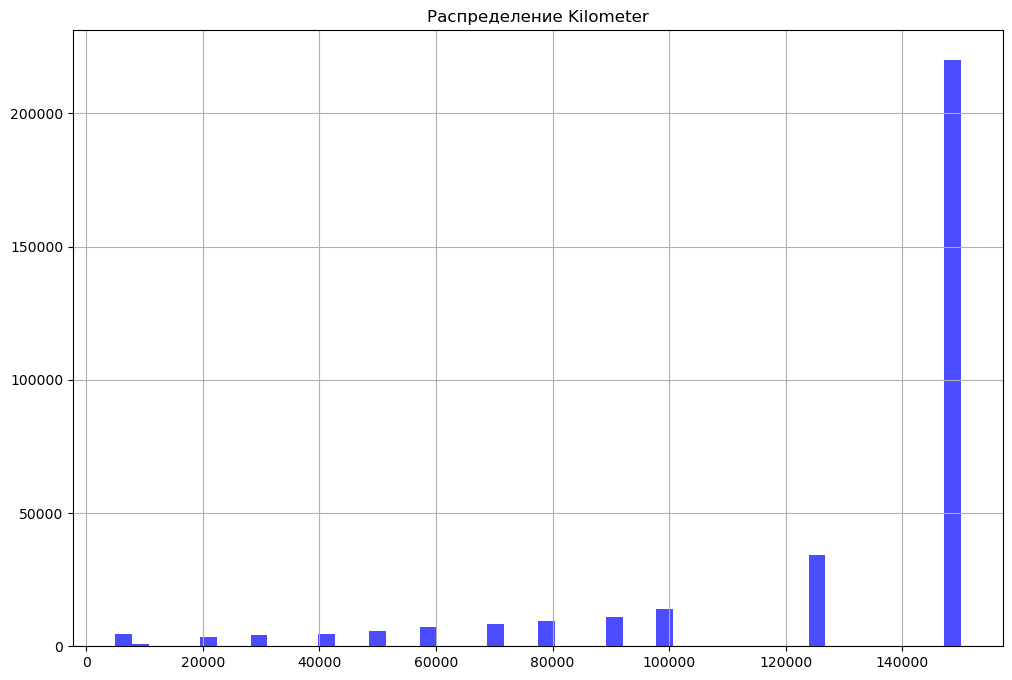

In [84]:
cars_df['Kilometer'].hist(figsize = (12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.title('Распределение Kilometer')
plt.show()

В колонку Kilometer данные при заполнении заполнялись из фиксированного справочника значений (5000, 10000, 20000 и т. д.), либо значения были разбиты на интервалы.

**Признаки - Gearbox, Repaired**

Категориальные признаки Gearbox и Repaired принимают только два значения. Для работы модели преобразуем значения этих признаков в числа '0' и '1', предварительно заполнив пропуски случайными числами '0' или '1'. Преобразуем тип данных у признаков `Gearbox` и `Repaired` в integer.

In [85]:
cars_df['Gearbox'] = cars_df['Gearbox'].fillna(
            pd.Series(np.random.randint(0, 2, size = len(cars_df)), index = cars_df.index))
cars_df.loc[cars_df['Gearbox'] == 'manual', 'Gearbox'] = 0
cars_df.loc[cars_df['Gearbox'] == 'auto', 'Gearbox'] = 1
cars_df['Gearbox'] = cars_df['Gearbox'].astype('int')
print(cars_df['Gearbox'].unique())

[0 1]


In [86]:
cars_df['Repaired'] = cars_df['Repaired'].fillna(
            pd.Series(np.random.randint(0, 2, size = len(cars_df)), index = cars_df.index))
cars_df.loc[cars_df['Repaired'] == 'no', 'Repaired'] = 0
cars_df.loc[cars_df['Repaired'] == 'yes', 'Repaired'] = 1
cars_df['Repaired'] = cars_df['Repaired'].astype('int')
print(cars_df['Repaired'].unique())

[1 0]


**Признаки - VehicleType, Model, FuelType**

У этих трех признаков одним из значений является 'other', поэтому заменим пропуски в этих столбцах на 'other'.

In [87]:
cars_df['VehicleType'] = cars_df['VehicleType'].fillna('other')
cars_df['Model'] = cars_df['Model'].fillna('other')
cars_df['FuelType'] = cars_df['FuelType'].fillna('other')

Удалим неинформативные для модели признаки:

- `DateCrawled` - дата скачивания анкеты из базы
- `RegistrationMonth` - месяц регистрации автомобиля
- `DateCreated` - дата создания анкеты
- `NumberOfPictures` - количество фотографий автомобиля
- `PostalCode` - почтовый индекс владельца анкеты
- `LastSeen` - дата последней активности пользователя

In [88]:
cars_df = cars_df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328359 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             328359 non-null  int64 
 1   VehicleType       328359 non-null  object
 2   RegistrationYear  328359 non-null  int64 
 3   Gearbox           328359 non-null  int64 
 4   Power             328359 non-null  int64 
 5   Model             328359 non-null  object
 6   Kilometer         328359 non-null  int64 
 7   FuelType          328359 non-null  object
 8   Brand             328359 non-null  object
 9   Repaired          328359 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 27.6+ MB


При помощи гистограмм визуализируем распределение переменных в итоговом датасете:

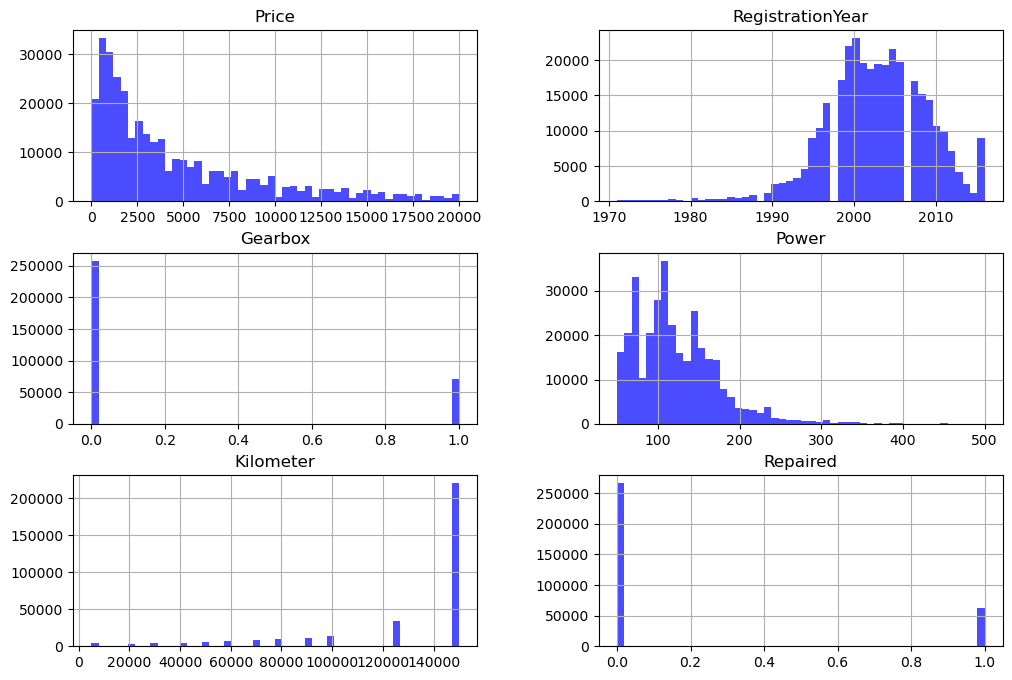

In [89]:
cars_df.hist(figsize = (12, 8), bins = 50, alpha = 0.7, color = 'blue')
plt.show()

Посмотрим взаимную корреляцию колонок датасета:

In [90]:
cars_df.corr()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
Price,1.000000,0.497898,0.223957,0.480877,-0.354926,-0.234966
RegistrationYear,0.497898,1.000000,0.034794,0.091823,-0.282207,-0.119948
Gearbox,0.223957,0.034794,1.000000,0.398233,0.008228,-0.010573
Power,0.480877,0.091823,0.398233,1.000000,0.091094,-0.056973
Kilometer,-0.354926,-0.282207,0.008228,0.091094,1.000000,0.075345
Repaired,-0.234966,-0.119948,-0.010573,-0.056973,0.075345,1.000000


Наблюдаем:
- Положительную кореляцию между признаками `RegistrationYear` и `Price`, `Power` и `Price`, более новые и мощные машины стоят дороже.
- Незначительная обратную корреляцию между признаками `Kilometer` и `Price`, `Repaired` и `Price`, с ростом пробега и после аварий цена машины падает.

**Вывод:**

В этом разделе были выполнены следующие задачи:

- Неинформативные признаки и явные дубликаты удалены.
- Аномалии в столбцах обработаны.
- Заполнены пропущенные значения в столбцах.

Данные подготовлены для обучения моделей.

<a id=3></a>
[Содержание](#0)
## 3. Подготовка данных

Подготовим три типа признаков для кроссвалидации:

- Неизмененные (original_)
- Закодированные методом OE (ordinal_)
- Закодированные методом OHE (ohe_)


In [91]:
cars_df_x = cars_df.drop('Price', axis = 1)
cars_df_y = cars_df['Price']

original_x_train, original_x_test, original_y_train, original_y_test = train_test_split(cars_df_x, cars_df_y,
                                                                train_size = 0.75, random_state = RND_STATE)
print('Размер тренерующей выборки:', original_x_train.shape)
print('Размер тестовой выборки:', original_x_test.shape)

Размер тренерующей выборки: (246269, 9)
Размер тестовой выборки: (82090, 9)


Данные из датасета cars_df подготовлены для модели градиентного бустинга CatBoost, т.к. CatBoost не распознаёт тип данных NaN.

Модели LightGBM и DecisionTreeRegressor не распознают тип данных 'object' (присутствующие в датасете cars_df), поэтому для их применения необходимо преобразовать категориальные признаки в численные.

Посмотрим, какие категориальные признаки нужно преобразовать в численные:

In [92]:
cat_columns = original_x_train.select_dtypes(include = 'object').columns.to_list()
display(cat_columns)

['VehicleType', 'Model', 'FuelType', 'Brand']

Создадим объект структуры данных OrdinalEncoder() и используем его для преобразования категориальных признаков:

In [93]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

cat_x = cars_df_x[cat_columns]
cat_x = pd.DataFrame(encoder.fit_transform(cat_x), columns = cat_x.columns, index = cat_x.index)
display(cat_x)

,VehicleType,Model,FuelType,Brand
0,3.0,116.0,6.0,38.0
1,2.0,166.0,2.0,1.0
2,6.0,117.0,2.0,14.0
3,5.0,116.0,6.0,38.0
4,5.0,101.0,2.0,31.0
...,...,...,...,...
354363,0.0,249.0,6.0,24.0
354365,3.0,166.0,5.0,33.0
354366,1.0,106.0,6.0,32.0
354367,0.0,224.0,2.0,38.0


In [94]:
ordinal_x = cars_df_x.copy()
display(ordinal_x)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,other,1993,0,106,golf,150000,petrol,volkswagen,1
1,coupe,2011,0,190,other,125000,gasoline,audi,1
2,suv,2004,1,163,grand,125000,gasoline,jeep,0
3,small,2001,0,75,golf,150000,petrol,volkswagen,0
4,small,2008,0,69,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...
354363,bus,2000,0,105,zafira,150000,petrol,opel,0
354365,other,2005,0,155,other,20000,other,sonstige_autos,0
354366,convertible,2000,1,101,fortwo,125000,petrol,smart,0
354367,bus,1996,0,102,transporter,150000,gasoline,volkswagen,0


In [95]:
for column in cat_columns:
    ordinal_x[column] = cat_x[column]
display(ordinal_x)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,3.0,1993,0,106,116.0,150000,6.0,38.0,1
1,2.0,2011,0,190,166.0,125000,2.0,1.0,1
2,6.0,2004,1,163,117.0,125000,2.0,14.0,0
3,5.0,2001,0,75,116.0,150000,6.0,38.0,0
4,5.0,2008,0,69,101.0,90000,2.0,31.0,0
...,...,...,...,...,...,...,...,...,...
354363,0.0,2000,0,105,249.0,150000,6.0,24.0,0
354365,3.0,2005,0,155,166.0,20000,5.0,33.0,0
354366,1.0,2000,1,101,106.0,125000,6.0,32.0,0
354367,0.0,1996,0,102,224.0,150000,2.0,38.0,0


In [96]:
ordinal_x_train = ordinal_x.loc[original_x_train.index, :]
ordinal_x_test = ordinal_x.loc[original_x_test.index, :]
print('Размер тренерующей выборки ordinal_x_train:', ordinal_x_train.shape)
print('Размер тестовой выборки ordinal_x_test:', ordinal_x_test.shape)

Размер тренерующей выборки ordinal_x_train: (246269, 9)
Размер тестовой выборки ordinal_x_test: (82090, 9)


In [97]:
ohe_x = pd.get_dummies(cars_df_x, drop_first = True)
display(ohe_x)

,RegistrationYear,Gearbox,Power,Kilometer,Repaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
0,1993,0,106,150000,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2011,0,190,125000,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2004,1,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,0,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,2008,0,69,90000,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2000,0,105,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354365,2005,0,155,20000,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
354366,2000,1,101,125000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354367,1996,0,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [98]:
ohe_x_train = ohe_x.loc[original_x_train.index, :]
ohe_x_test = ohe_x.loc[original_x_test.index, :]
print('Размер тренерующей выборки ohe_x_train:', ohe_x_train.shape)
print('Размер тестовой выборки ohe_x_test:', ohe_x_test.shape)

Размер тренерующей выборки ohe_x_train: (246269, 306)
Размер тестовой выборки ohe_x_test: (82090, 306)


Создадим отдельный набор данных (*_2) для OneHotEncoder()

In [99]:
cat_columns_2 = original_x_train.select_dtypes(include = 'object').columns.to_list()
# Если при кодировании значений признаков много и ядро Jupiter вылетает можно убрать признак 'Model' из кодирования
# cat_columns_2.remove('Model')
print(cat_columns_2)

['VehicleType', 'Model', 'FuelType', 'Brand']


In [100]:
ohe_x_2 = cars_df_x.copy()
display(ohe_x_2)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,other,1993,0,106,golf,150000,petrol,volkswagen,1
1,coupe,2011,0,190,other,125000,gasoline,audi,1
2,suv,2004,1,163,grand,125000,gasoline,jeep,0
3,small,2001,0,75,golf,150000,petrol,volkswagen,0
4,small,2008,0,69,fabia,90000,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...
354363,bus,2000,0,105,zafira,150000,petrol,opel,0
354365,other,2005,0,155,other,20000,other,sonstige_autos,0
354366,convertible,2000,1,101,fortwo,125000,petrol,smart,0
354367,bus,1996,0,102,transporter,150000,gasoline,volkswagen,0


In [101]:
# Из-за старой версии sklearn.preprocessing на сайте могут возникать 2 проблемы:
# 1. При инициализации с двумя параметрами:
#    drop = 'first'
#    handle_unknown = 'ignore'
#  Jupiter вылетает с ошибкой: "ValueError: `handle_unknown` must be 'error' when the drop parameter is specified,
#  as both would create categories that are all zero."
#  Можно оставить только первый парамет, хотя второй не менее важен.
#
# >> encoder_ohe = OneHotEncoder(drop = 'first', sparse = False)
#
# 2. Другое название у функции, которая возвращает список новых параметров:
#    encoder_ohe.get_feature_names(), вместо
#    encoder_ohe.get_feature_names_out()
#
# >> ohe_x_2[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(ohe_x_2[cat_columns_2])
#
# Если загрузить блокнот в приложение Jupiter (а не web), с актуальной версией библиотеки, все отработает нормально!

encoder_ohe = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse = False)
encoder_ohe.fit(ohe_x_2[cat_columns_2])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

Посмотрим категории каждого признака:

In [102]:
encoder_ohe.categories_

[array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
        'wagon'], dtype=object),
 array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
        '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
        '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
        '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
        'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
        'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
        'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
        'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
        'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
        'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
        'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
        'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
        'crossfire', 'cuore', 'cx_reihe', 'defend

Добавляем закодированные признаки в ohe_x_2:

In [103]:
ohe_x_2[encoder_ohe.get_feature_names()] = encoder_ohe.transform(ohe_x_2[cat_columns_2])

Удаляем незакодированные категориальные признаки (изначальные колонки):

In [104]:
ohe_x_2 = ohe_x_2.drop(cat_columns_2, axis = 1)
display(ohe_x_2)

,RegistrationYear,Gearbox,Power,Kilometer,Repaired,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,...,x3_seat,x3_skoda,x3_smart,x3_sonstige_autos,x3_subaru,x3_suzuki,x3_toyota,x3_trabant,x3_volkswagen,x3_volvo
0,1993,0,106,150000,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2011,0,190,125000,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,1,163,125000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2001,0,75,150000,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2008,0,69,90000,0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2000,0,105,150000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354365,2005,0,155,20000,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
354366,2000,1,101,125000,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
354367,1996,0,102,150000,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [105]:
ohe_x_2_train = ohe_x_2.loc[original_x_train.index, :]
ohe_x_2_test = ohe_x_2.loc[original_x_test.index, :]
print('Размер тренерующей выборки ohe_x_2_train:', ohe_x_2_train.shape)
print('Размер тестовой выборки ohe_x_2_test:', ohe_x_2_test.shape)

Размер тренерующей выборки ohe_x_2_train: (246269, 306)
Размер тестовой выборки ohe_x_2_test: (82090, 306)


<a id=4></a>
[Содержание](#0)
## 4. Обучение моделей

Зададим параметры для кроссвалидации:

In [106]:
kf = KFold(n_splits = 5, random_state = RND_STATE, shuffle = True)

Сохраним результаты в таблицу *scores_data*:

In [107]:
scores_data = []

**4.1. DecisionTreeRegressor**

Обучим модель на признаках, закодированных по методу OE:

In [108]:
%%time

regressor = DecisionTreeRegressor()
hyperparams = [{'criterion': ['squared_error'], #['mse'],
                'max_depth':range(1, 31, 1),
                'min_samples_leaf': [ 1, 2]}]

print('Подбор гиперпараметров для DecisionTreeRegressor:')
grid = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = -1, verbose = 1)
grid.fit(ordinal_x_train, original_y_train)

res = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_]
rmse = round((res['mean_test_score'] * -1) ** 0.5, 0)
fit_time = round(res['mean_fit_time'], 2)
score_time = round(res['mean_score_time'], 2)
print()
print("Лучший набор параметров:", grid.best_params_)
print('Лучшее значение RMSE:', rmse)
print('Время обучения модели:', fit_time, 's')
print('Время предсказания модели:', score_time, 's')
print()
scores_data.append(['DecisionTreeRegressor on OE features', rmse, fit_time, score_time])

Подбор гиперпараметров для DecisionTreeRegressor:
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Лучший набор параметров: {'criterion': 'squared_error', 'max_depth': 15, 'min_samples_leaf': 2}
Лучшее значение RMSE: 1907.0
Время обучения модели: 0.42 s
Время предсказания модели: 0.01 s

CPU times: user 1.12 s, sys: 583 ms, total: 1.7 s
Wall time: 15.8 s


Обучим модель на признаках, закодированных по методу OHE:

In [109]:
%%time

regressor = DecisionTreeRegressor()
hyperparams = [{'criterion': ['squared_error'], #['mse'],
                'max_depth':range(1, 31, 1),
                'min_samples_leaf': [ 1, 2]}]

print('Подбор гиперпараметров для DecisionTreeRegressor:')
grid = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = -1, verbose = 1)
grid.fit(ohe_x_2_train, original_y_train)

res = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_]
rmse = round((res['mean_test_score'] * -1) ** 0.5, 0)
fit_time = round(res['mean_fit_time'], 2)
score_time = round(res['mean_score_time'], 2)
print()
print("Лучший набор параметров:", grid.best_params_)
print('Лучшее значение RMSE:', rmse)
print('Время обучения модели:', fit_time, 's')
print('Время предсказания модели:', score_time, 's')
print()
scores_data.append(['DecisionTreeRegressor on OHE features', rmse, fit_time, score_time])

Подбор гиперпараметров для DecisionTreeRegressor:
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Лучший набор параметров: {'criterion': 'squared_error', 'max_depth': 21, 'min_samples_leaf': 2}
Лучшее значение RMSE: 1872.0
Время обучения модели: 13.27 s
Время предсказания модели: 0.17 s

CPU times: user 5.21 s, sys: 3.57 s, total: 8.77 s
Wall time: 5min 47s


**4.2. CatBoostRegressor**

Обучим модель на признаках, закодированных по методу OE:

In [110]:
%%time

regressor = CatBoostRegressor(iterations = 250,
                              early_stopping_rounds = 10,
                              l2_leaf_reg = 4,
                              verbose = False)

hyperparams = [{'learning_rate':[0.3, 0.5],
                'depth': [9, 11, 13],
               }]

print('Подбор гиперпараметров для CatBoostRegressor:')
grid = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = -1)
grid.fit(ordinal_x_train, original_y_train)

res = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_]
rmse = round((res['mean_test_score'] * -1) ** 0.5, 0)
fit_time = round(res['mean_fit_time'], 2)
score_time = round(res['mean_score_time'], 2)
print()
print("Лучший набор параметров:", grid.best_params_)
print('Лучшее значение RMSE:', rmse)
print('Время обучения модели:', fit_time, 's')
print('Время предсказания модели:', score_time, 's')
print()
scores_data.append(['CatBoostRegressor on OE features', rmse, fit_time, score_time])

Подбор гиперпараметров для CatBoostRegressor:

Лучший набор параметров: {'depth': 13, 'learning_rate': 0.3}
Лучшее значение RMSE: 1602.0
Время обучения модели: 29.15 s
Время предсказания модели: 0.03 s

CPU times: user 20.9 s, sys: 1.57 s, total: 22.4 s
Wall time: 59.5 s


Обучим модель на оригинальных данных с указанием категорий:

In [111]:
%%time

regressor = CatBoostRegressor(iterations = 250,
                              early_stopping_rounds = 10,
                              l2_leaf_reg = 4,
                              cat_features = cat_columns,
                              verbose = False)

hyperparams = [{'learning_rate':[0.3, 0.5],
                'depth': [9, 11, 13],
               }]

print('Подбор гиперпараметров для CatBoostRegressor:')
grid = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = -1)
grid.fit(original_x_train, original_y_train)

res = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_]
rmse = round((res['mean_test_score'] * -1) ** 0.5, 0)
fit_time = round(res['mean_fit_time'], 2)
score_time = round(res['mean_score_time'], 2)
print()
print("Лучший набор параметров:", grid.best_params_)
print('Лучшее значение RMSE:', rmse)
print('Время обучения модели:', fit_time, 's')
print('Время предсказания модели:', score_time, 's')
print()
scores_data.append(['CatBoostRegressor on original features', rmse, fit_time, score_time])

Подбор гиперпараметров для CatBoostRegressor:

Лучший набор параметров: {'depth': 13, 'learning_rate': 0.3}
Лучшее значение RMSE: 1603.0
Время обучения модели: 109.58 s
Время предсказания модели: 0.1 s

CPU times: user 2min 1s, sys: 3.43 s, total: 2min 4s
Wall time: 4min 33s


**4.3. LGBMRegressor**

In [112]:
%%time

regressor = LGBMRegressor(boosting_type = 'gbdt',
                          metric = 'rmse',
                          num_leaves = 80,
                          verbose = -1)

hyperparams = { 'n_estimators':[100, 200],
                'learning_rate':[0.1, 0.3],
                'max_depth': [5, 7, 9] }

print('Подбор гиперпараметров для LGBMRegressor:')
grid = GridSearchCV(regressor, hyperparams, scoring = 'neg_mean_squared_error', cv = kf, n_jobs = -1)
grid.fit(ordinal_x_train, original_y_train)

res = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_]
rmse = round((res['mean_test_score'] * -1) ** 0.5, 0)
fit_time = round(res['mean_fit_time'], 2)
score_time = round(res['mean_score_time'], 2)
print()
print("Лучший набор параметров:", grid.best_params_)
print('Лучшее значение RMSE:', rmse)
print('Время обучения модели:', fit_time, 's')
print('Время предсказания модели:', score_time, 's')
print()
scores_data.append(['LGBMRegressor on OE features', rmse, fit_time, score_time])

Подбор гиперпараметров для LGBMRegressor:

Лучший набор параметров: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200}
Лучшее значение RMSE: 1613.0
Время обучения модели: 1.31 s
Время предсказания модели: 0.46 s

CPU times: user 5.73 s, sys: 2.14 s, total: 7.87 s
Wall time: 14.3 s


Полученные результаты по моделям собраны в итоговую таблицу:

In [113]:
result = pd.DataFrame(scores_data)
result.columns = ['Model', 'RMSE', 'Fit_time', 'Score_time']
result.set_index('RMSE', inplace = True)
display(result.sort_values('RMSE'))

,Model,Fit_time,Score_time
RMSE,,,
1602.0,CatBoostRegressor on OE features,29.15,0.03
1603.0,CatBoostRegressor on original features,109.58,0.10
1613.0,LGBMRegressor on OE features,1.31,0.46
1872.0,DecisionTreeRegressor on OHE features,13.27,0.17
1907.0,DecisionTreeRegressor on OE features,0.42,0.01


**Вывод:**

Были изучены 3 модели с разными вариантами представления исходных данных, найдены лучшие гиперпараметры и временные параметры обучения и предсказания.

С **RMSE = 1602** лучшей моделью является **CatBoostRegressor on OE features**, обученная на признаках, закодированных по методу OE (порядкового кодирования).

Незначительно от нее отстает с **RMSE = 1603** модель **CatBoostRegressor on original features**, обученная на оригинальных данных с указанием категорий. Но эта модель имеет большее время обучения и предсказания (109s, 0.1s), по сравнению с лидером (29s, 0.03s).

Немного отстает с RMSE = 1613 модель **LGBMRegressor on OE features**, обученная на признаках, закодированных по методу OE (порядкового кодирования), с меньшим временем обучения 1.3s и большим предсказания 0.46s.

Опираясь на критерии заказчика и по совокупности факторов, выберем лучшую модель **CatBoostRegressor on OE features**.

<a id=5></a>
[Содержание](#0)
## 5. Тестирование модели

Проверим качество лучшей модели **CatBoostRegressor on OE features** на тестовой выборке:

In [114]:
%%time

model = CatBoostRegressor(iterations = 250,
                          early_stopping_rounds = 10,
                          l2_leaf_reg = 4,
                          learning_rate = 0.3,
                          depth = 13,
                          verbose = False,
                          random_state = RND_STATE) 

model.fit(ordinal_x_train, original_y_train)
predicted = model.predict(ordinal_x_test)
rmse = mean_squared_error(original_y_test, predicted, squared = False)
print('Значение RMSE на тестовых данных:', rmse)

Значение RMSE на тестовых данных: 1576.097484813155
CPU times: user 21.4 s, sys: 1.42 s, total: 22.9 s
Wall time: 7.01 s


**Вывод:**

Выбранная модель **CatBoostRegressor on OE features** на тестовой выборке имеет метрику оценки качества **RMSE = 1576**.

Во всех рассмотренных моделях значение метрики RMSE не превышает 2500, как и изначально требовалось по условию задачи проекта.

<a id=6></a>
[Содержание](#0)
## 6. Общий вывод

Проведено исследование с целью построить модель для определения рыночной стоимости своего автомобиля.

Входные данные - исторические данные: технические характеристики, комплектации и цены автомобилей.

В результате исследования удалось получить следующие результаты на обучающей выборке для модели градиентного бустинга **CatBoostRegressor on OE features**:

- Метрика оценки качества RMSE = 1576
- Время обучения модели: 7.01 s
- Время предсказания модели: 0.01 s

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» может использовать полученную модель для быстрой оценки рыночной стоимости автомобиля для привлечения новых клиентов в своем приложении.